In [4]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

import topojson

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
PARQA = os.getenv('PARQA')


## Districts Dats

In [6]:
distrPath  = PARQA + '/data/distr.json'
distr = gp.read_file(distrPath)

In [7]:
distr.head(2)

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,POLYGON ((-74.01762658084725 40.70402350035151...,0
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,POLYGON ((-74.01157713042129 40.72620526762934...,1


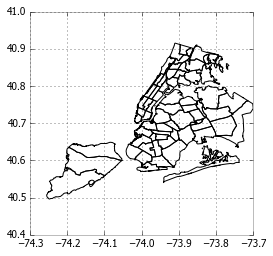

In [8]:
distr.plot(alpha=.0)

## SCORE TIMESERIES

## Read Calls

In [7]:
calls = pd.read_csv(PARQA + '/data/311/MatchedCalls.cav',index_col=0)

In [8]:
calls.head()

,Closed Date,Created Date,Location Type,NAME,Complaint Type,Descriptor,lat,lon,parkDistrict
0,01/03/2011 12:03:59 PM,12/31/2010 09:04:48 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.931120,40.668798,B-09
3,01/03/2011 09:41:24 AM,12/31/2010 03:36:37 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.962835,40.688556,B-02
4,01/03/2011 12:15:38 PM,12/31/2010 03:03:16 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.999809,40.636935,B-12
6,01/03/2011 12:23:04 PM,12/31/2010 12:59:59 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.999456,40.609951,B-11
7,01/03/2011 12:19:51 PM,12/31/2010 12:12:02 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.977616,40.633153,B-14


## Aggregating Funct Area per district

In [9]:
calls['Created Date'] = pd.to_datetime(calls['Created Date']) # 

In [10]:
calls15 = calls[calls['Created Date'].dt.year==2015]

In [11]:
dCalls = calls15.groupby('parkDistrict').size().reset_index().rename(columns={0:'calls2015','parkDistrict':'SYSTEM'})
dCalls.head()

,SYSTEM,calls2015
0,B-01,619
1,B-02,614
2,B-03,447
3,B-04,125
4,B-05,282


In [12]:
distr2 = distr.merge(dCalls, how='left', on='SYSTEM')

In [13]:
distr2.head()

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id,calls2015
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,POLYGON ((-74.01762658084725 40.70402350035151...,0,268
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,POLYGON ((-74.01157713042129 40.72620526762934...,1,240
2,None,M,104,"3, 6",48977247.921813,61207.299629,M-04,POLYGON ((-74.00962132028943 40.74295242326271...,2,244
3,None,M,105,"3, 4, 6, 2",43791924.743732,35294.228236,M-05,POLYGON ((-73.97236228553678 40.75649783412324...,3,111
4,None,M,106,"3, 4, 5, 2",38665192.246746,38619.804200,M-06,(POLYGON ((-73.96442970287988 40.7467163274655...,4,253


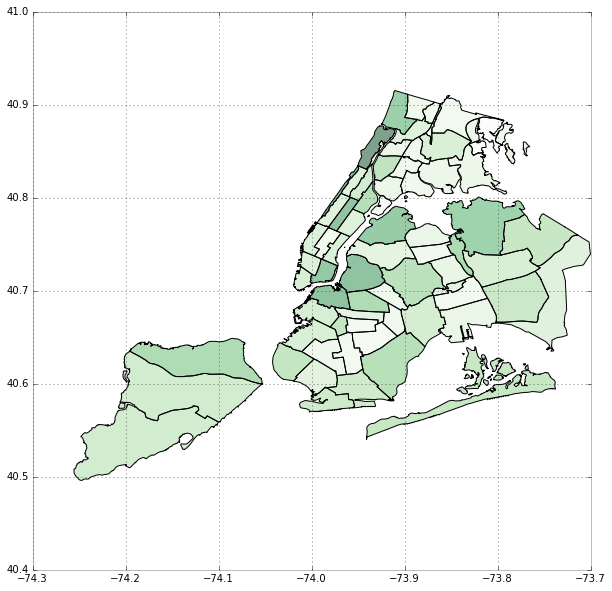

In [14]:
distr2.plot(column='calls2015', colormap='Greens', figsize=(10,10) )

## Read Scores

In [15]:
scores = pd.read_csv(PARQA + 'parqa/311/TIMESERIES/PIP_score_timeseries.csv',index_col=0)

In [16]:
scores = scores[['2015',
                 'District']][scores.score_type == 'Amenities & Area Normalized Score'].rename(columns={'District':'SYSTEM',
                                                                                                        '2015':'PIPscore'})

In [17]:
scores.head(2)

,PIPscore,SYSTEM
2,0.824545,B-01
5,0.873778,B-02


In [18]:
distr3 = distr2.merge(scores, how='left', on='SYSTEM')

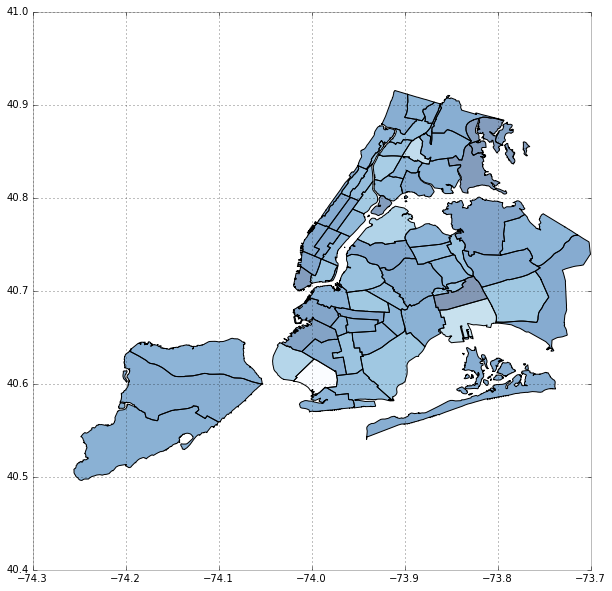

In [19]:
distr3.plot(column='PIPscore', colormap='Blues', figsize=(10,10) );

In [27]:
print '311 Calls'
print distr3.calls2015.min(), distr3.calls2015.max(), 

311 Calls
8 816


In [26]:
print 'PIP_score'
print distr3.PIPscore.min(), distr3.PIPscore.max()

PIP_score
0.47857549972 0.991653017545


In [29]:
distr3[distr3['SYSTEM']=='B-11']

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id,calls2015,PIPscore
31,None,B,311,"38, 43, 44, 47, 50",1.031081e+08,48882.488784,B-11,POLYGON ((-73.99449181376833 40.58873639858856...,31,209,0.478575


## SAVE to geojson

In [20]:
path = PARQA + '/Parqa_tool/data/districts.json'

with open(path,'w') as f:
    f.write(distr3.to_json())

## Save to topojson

In [22]:
from topojson import topojson

#give it a path in and out
topojson(path,path.replace('.json','_t.json'), quantization=1e6, simplify=0.0001)